In [1]:
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('seaborn')
import datetime
import h5py
import copy
from MC_file import MC

In [2]:
#2D Lattice number
L = 10
#set layer number
Layer_nums=2

# Markov chain warmup
warmup = 2.5e3
# Markov chain total steps
updates = warmup + 5e2

#spin for per Mn atom in MnBi2Te4
S=5/2

#exchange coefficient J/k_b. nearest neighbour lattice
J_intra = S*0.35*1.602e-22/1.381e-23

#Magnetocrystalline Anisotropy Energy
K = S*0.07*1.602e-22/1.381e-23

#exchange coefficient J/k_b. nearest neighbour layer
J_inter=-S*0.088*1.602e-22/1.381e-23

#Magnetic field
#one_uB=5.788*1e-5eV/T
#Apply 1T magnetic field along Z direction
Field = 1
B=S*(5.788*2*0.01*1.602e-22/1.381e-23)*Field

#
data_num = 50

#Temperature
T = np.linspace(1,50,data_num)

#Initialization spin
data_spin = np.zeros([Layer_nums,L,L,3])

for ee in range(Layer_nums):
	for ii in range(L):
		for jj in range(L):
			
			##Spin Random initialization
			#data_spin[ii,jj,kk,:] = np.random.rand(3)*2-1
			#tmp = data_spin[ii,jj,kk,:]
			#tmp = np.array(tmp)
			#data_spin[ii,jj,kk,:] = tmp/np.sqrt(tmp@tmp)

			#Initialize spin along Z axis
			data_spin[ee,ii,jj,2] = 1.0

In [3]:
%%time

#Store magnetization data
Mag = np.zeros(data_num)
Mag_2 = np.zeros(data_num)

#Store  magnetization for Z axis data
Mag_Z=np.zeros(data_num)
Mag_Z_2=np.zeros(data_num)

#Store  Energy data 
E = np.zeros(data_num)
E_2 = np.zeros(data_num)

# Initailize the Monte carlo parameter, acccept_rate and sigma
acccept_rate = np.ones((int(data_num),int(updates)))*0.0
sigma = np.ones((int(data_num),int(updates)))*60.0


with h5py.File('124_MT.hdf5', 'w') as f:#define a file name
	for ii in range(data_num):

		counter = 0
		#Record the spin data when Markov chain stochastic process come into steady state
		The_data_spin_collect=[] 

		mc=MC(Layer_nums=Layer_nums,L=L,J_intra=J_intra,J_inter=J_inter,K=K,B=B,T=T[ii])
		
		for jj in range(int(updates)): 
					
			#Metropolis-Hasting algorithm
			tmp = mc.Metropolis(data_spin=data_spin,acccept_rate=acccept_rate[ii,jj],sigma=sigma[ii,jj])

			#update spin 
			data_spin = tmp[0]

			#update MC parameter 
			if jj < int(updates)-1:
				acccept_rate[ii,jj+1] = tmp[1]
				sigma[ii,jj+1] = tmp[2]

			if jj >= warmup: #and jj%2 == 0:

				counter += 1
				
				#store the spin for Z direction
				The_data_spin_collect.append(copy.deepcopy(data_spin[:,:,:,2]))
				
				# daset=grp.create_dataset(str(jj-warmup), data=data_spin[0:Layer_nums,:,:,2])

				M = mc.Summation(data_spin)
				Mag[ii] += M
				Mag_2[ii] += M**2
	
				M_z=mc.Summation_Z(data_spin)
				Mag_Z[ii] += M_z
				Mag_Z_2[ii] += M_z**2


				Energy=mc.H(data_spin)
				E[ii] += Energy
				E_2[ii] += Energy**2

		#store the spin data into hdf5 file
		f.create_dataset(str(T[ii])+'K', data=The_data_spin_collect)

		#Calculate the average and square data for magnetization 
		Mag[ii] = Mag[ii]/counter
		Mag_2[ii] =Mag_2[ii] /counter

		#Calculate the average and square data for z axis magnetization 
		Mag_Z[ii]=Mag_Z[ii]/counter
		Mag_Z_2[ii]=Mag_Z_2[ii]/counter

		#Calculate the average and square data for system energy 
		E[ii] = E[ii]/counter
		E_2[ii] = E_2[ii]/counter
		

		if ii<=5 or ii%10==0:
			print('{} data_spin_for_{}_K is finishied'.format(datetime.datetime.now(),T[ii]))

C_v = 1/T**2*(E_2-E**2)
Susceptibility_Z=(1/T)*(Mag_Z_2-Mag_Z**2)
Susceptibility=(1/T)*(Mag_2-Mag**2)

2023-03-03 16:19:48.710829 data_spin_for_1.0_K is finishied
2023-03-03 16:20:35.575748 data_spin_for_2.0_K is finishied
2023-03-03 16:21:22.707912 data_spin_for_3.0_K is finishied
2023-03-03 16:22:10.077293 data_spin_for_4.0_K is finishied
2023-03-03 16:22:57.951137 data_spin_for_5.0_K is finishied
2023-03-03 16:23:45.341538 data_spin_for_6.0_K is finishied
2023-03-03 16:27:34.089699 data_spin_for_11.0_K is finishied
2023-03-03 16:35:10.450020 data_spin_for_21.0_K is finishied
2023-03-03 16:43:03.175756 data_spin_for_31.0_K is finishied
2023-03-03 16:50:53.821730 data_spin_for_41.0_K is finishied
Wall time: 38min 44s


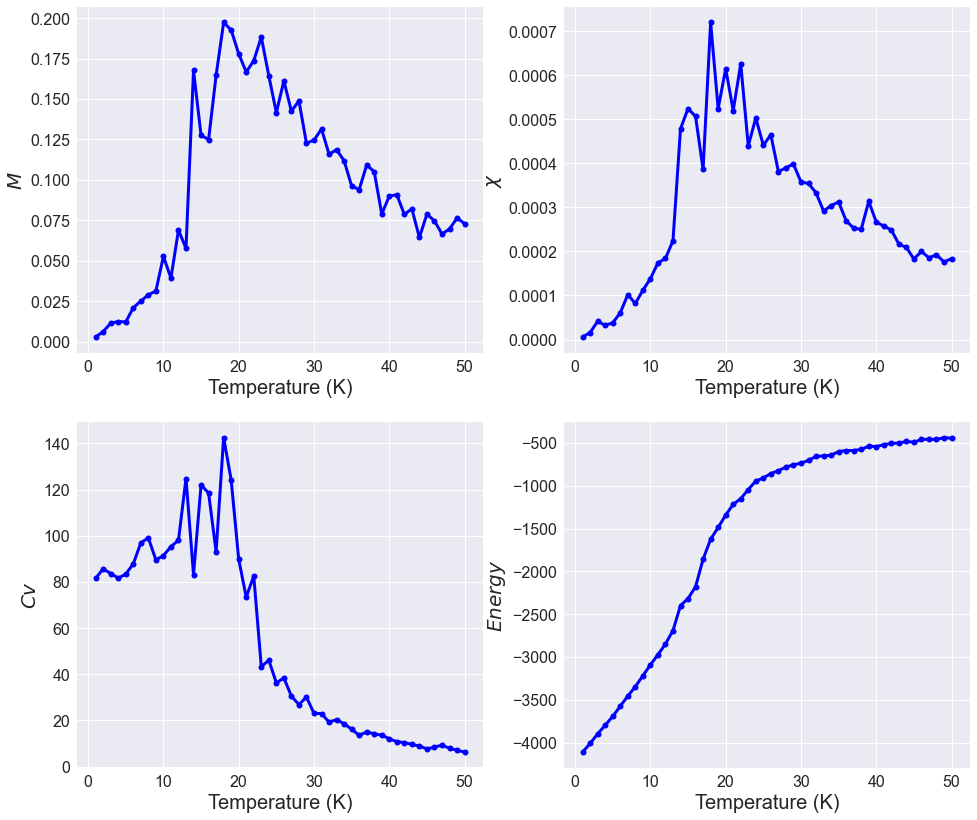

In [9]:
fig = plt.figure(figsize=(16,14))

#plot Magetization
ax1 = plt.subplot(221)
ax1.plot(T,Mag_Z,'bo-',markersize=6,lw=3)
ax1.set_xlabel('Temperature (K)',fontsize=20)
ax1.set_ylabel(r'$M$',fontsize=20) 
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)  
# ax1.set_title('Four layers',fontsize=20)

#plot Susceptibility
ax2 = plt.subplot(222)
ax2.plot(T,Susceptibility_Z,'bo-',markersize=6,lw=3)
ax2.set_xlabel('Temperature (K)',fontsize=20)
ax2.set_ylabel(r'$\chi$',fontsize=20) 
plt.xticks(fontsize=16)
plt.yticks(fontsize=16) 
# ax2.set_title('Two layers',fontsize=20)

#plot Specific heat
ax3 = plt.subplot(223)
ax3.plot(T,C_v,'bo-',markersize=6,lw=3)
ax3.set_xlabel('Temperature (K)',fontsize=20)
ax3.set_ylabel(r'$Cv$',fontsize=20) 
plt.xticks(fontsize=16)
plt.yticks(fontsize=16) 

#plot system energy
ax4 = plt.subplot(224)
ax4.plot(T,E,'bo-',markersize=6,lw=3)
ax4.set_xlabel('Temperature (K)',fontsize=20)
ax4.set_ylabel(r'$Energy$',fontsize=20) 
plt.xticks(fontsize=16)
plt.yticks(fontsize=16) 

plt.show()

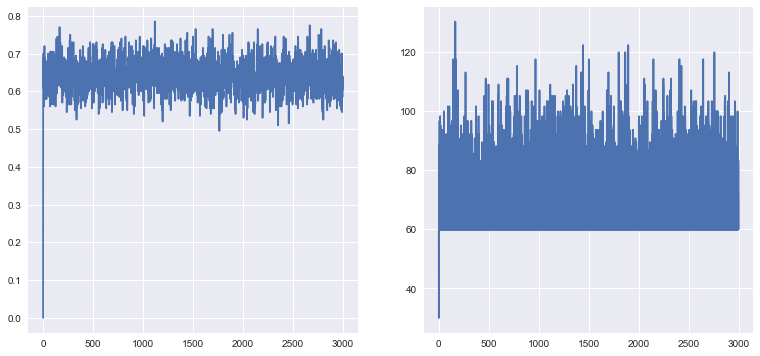

In [6]:
fig = plt.figure(figsize=(13,6))
ii=26
ax1 = plt.subplot(121)
ax1.plot(acccept_rate[ii])

ax2 = plt.subplot(122)
ax2.plot(sigma[ii])